In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import sys
import torch.nn as nn
import torch
sys.path.append("./set_transformer")
from modules import ISAB, PMA, SAB
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split
def build_dataset():
    data_gpaw = pd.read_pickle("data/gpaw_forces_dataframe.pickle")
    data_vasp = pd.read_pickle("data/VASP_MoS2_defects.pickle")
    assert (data_vasp.structures.iloc[0].lattice._matrix == data_gpaw.structure.iloc[0].cell.array).all()
    
    positions = np.concatenate([i.positions[np.newaxis, :, :] for i in data_gpaw.structure] +
                               [i.cart_coords[np.newaxis, :, :] for i in data_vasp.structures],
                               axis=0).astype(np.float32)
    #positions -= positions.mean(axis=(0,1), keepdims=True)
    #positions /= positions.std(axis=(0,1), keepdims=True)
    
    energies = np.concatenate([data_gpaw.energy.values, data_vasp.energy.values]).astype(np.float32)
    energies -= energies.mean()
    
    forces = np.concatenate([f[np.newaxis, :, :] for f in data_gpaw.forces] +
                            [np.zeros((len(data_vasp), positions.shape[1], positions.shape[2]), dtype=np.float32)],
                            axis=0).astype(np.float32)
    
    types = np.concatenate([i.get_atomic_numbers()[np.newaxis, :] for i in data_gpaw.structure] + 
                           [np.array(i.atomic_numbers)[np.newaxis, :] for i in data_vasp.structures],
                           axis=0).astype(np.int32)
    return list(map(np.array,
                    train_test_split(positions, types, energies, forces, test_size=0.25, random_state=1421))),\
           data_gpaw.structure.iloc[0].cell.array.astype(np.float32)

In [5]:
class SetTransformer(nn.Module):
    def __init__(
        self,
        dim_input=4,
        num_outputs=1,
        dim_output=1,
        num_inds=32,
        dim_hidden=128,
        num_heads=4,
        ln=False,
    ):
        super(SetTransformer, self).__init__()
        self.enc = nn.Sequential(
            ISAB(dim_input, dim_hidden, num_heads, num_inds, ln=ln),
            ISAB(dim_hidden, dim_hidden, num_heads, num_inds, ln=ln),
            ISAB(dim_hidden, dim_hidden, num_heads, num_inds, ln=ln),
            ISAB(dim_hidden, dim_hidden, num_heads, num_inds, ln=ln),
            ISAB(dim_hidden, dim_hidden, num_heads, num_inds, ln=ln),
            ISAB(dim_hidden, dim_hidden, num_heads, num_inds, ln=ln),
            ISAB(dim_hidden, dim_hidden, num_heads, num_inds, ln=ln),
        )
        self.dec = nn.Sequential(
            nn.Dropout(),
            PMA(dim_hidden, num_heads, num_outputs, ln=ln),
            nn.Dropout(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.ReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.ReLU(),
            nn.Linear(dim_hidden, dim_output),
        )

    def forward(self, X):
        return self.dec(self.enc(X)).squeeze()

In [6]:
(positions, test_positions, \
types, test_types, \
energies, test_energies, \
forces, test_forces), lattice = build_dataset()
species = (types==types[0,0]).astype(np.float32)
energy_mean = np.mean(energies)
print('positions.shape = {}'.format(positions.shape))
print('<E> = {}'.format(energy_mean))

positions.shape = (616, 105, 3)
<E> = 0.01615886017680168


In [7]:
model = SetTransformer(dim_hidden=256, num_heads=4, num_inds=16).cuda()

./set_transformer/modules.py:46: UserWarning:

Legacy tensor constructor is deprecated. Use: torch.tensor(...) for creating tensors from tensor-like objects; or torch.empty(...) for creating an uninitialized tensor with specific sizes. (Triggered internally at  /temporary/pytorch/torch/csrc/utils/tensor_new.cpp:477.)



In [8]:
inputs_t = torch.Tensor(np.concatenate([positions, np.expand_dims(species, -1)], axis=2)).cuda()
energies_t = torch.Tensor(energies).cuda()

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()
losses = []

In [10]:
model.train()
for iteration in range(30):
  preds = model(inputs_t)
  loss = criterion(preds, energies_t)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  losses.append(loss.item())
  print(f"Train RMSE {np.sqrt(losses[-1]):.3f} eV")

Train RMSE 0.753 eV
Train RMSE 0.738 eV
Train RMSE 0.738 eV
Train RMSE 0.738 eV
Train RMSE 0.741 eV
Train RMSE 0.738 eV
Train RMSE 0.738 eV
Train RMSE 0.740 eV
Train RMSE 0.739 eV
Train RMSE 0.738 eV
Train RMSE 0.735 eV
Train RMSE 0.739 eV
Train RMSE 0.738 eV
Train RMSE 0.743 eV
Train RMSE 0.738 eV
Train RMSE 0.737 eV
Train RMSE 0.737 eV
Train RMSE 0.738 eV
Train RMSE 0.739 eV
Train RMSE 0.739 eV
Train RMSE 0.737 eV
Train RMSE 0.735 eV
Train RMSE 0.736 eV
Train RMSE 0.741 eV
Train RMSE 0.734 eV
Train RMSE 0.741 eV
Train RMSE 0.738 eV
Train RMSE 0.738 eV
Train RMSE 0.741 eV
Train RMSE 0.742 eV


In [11]:
preds_np = preds.cpu().detach().numpy()

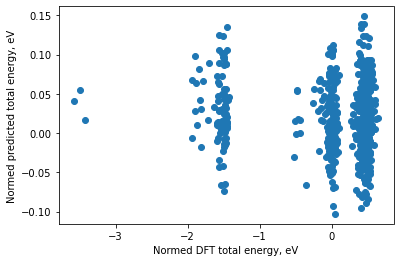

In [12]:
fig, ax = plt.subplots()
ax.scatter(energies, preds_np)
ax.set_ylabel("Normed predicted total energy, eV")
ax.set_xlabel("Normed DFT total energy, eV");